# **Restaurant Review Rating Analysis**

## 1. Setup and Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
!pip install wordcloud
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Restaurant-reviews.csv')

# Preview the data
df.head()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2. Data Preprocessing


### 2.1 Text Preprocessing


In [ ]:
# Check for non-numeric values in 'Rating' and convert them to NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Drop rows with NaN values in 'Rating'
df = df.dropna(subset=['Rating'])

# Preprocess text function
def preprocess_text(text):
    if isinstance(text, str):
        # Remove non-alphabet characters and convert to lowercase
        text = re.sub(pattern='[^a-zA-Z]', repl=' ', string=text).lower()

        # Tokenize and remove stopwords
        tokens = text.split()
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        return tokens  # Return tokens for Word2Vec
    else:
        return []

# Apply text preprocessing
df['Processed_Text'] = df['Review'].apply(preprocess_text)

# Ensure 'Review' is a string to avoid errors
df['Review'] = df['Review'].astype(str)

## 3. Data Visualization



### 3.1 WordCloud for Positive Reviews (Ratings > 3)


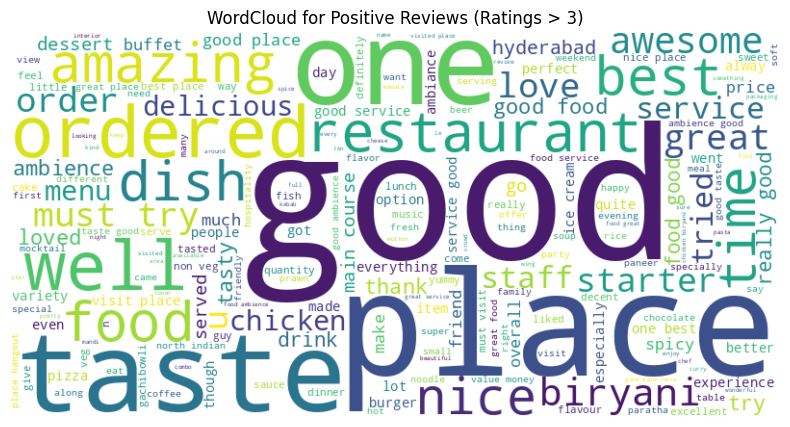

In [ ]:
# Join the words within each list in the 'Processed_Text' column first.
positive_reviews = ' '.join([' '.join(tokens) for tokens in df[df['Rating'] > 3]['Processed_Text']])

# Now you have a string 'positive_reviews' containing all words from positive reviews.

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Positive Reviews (Ratings > 3)')
plt.show()

### 3.2 WordCloud for Negative Reviews (Ratings <= 3)


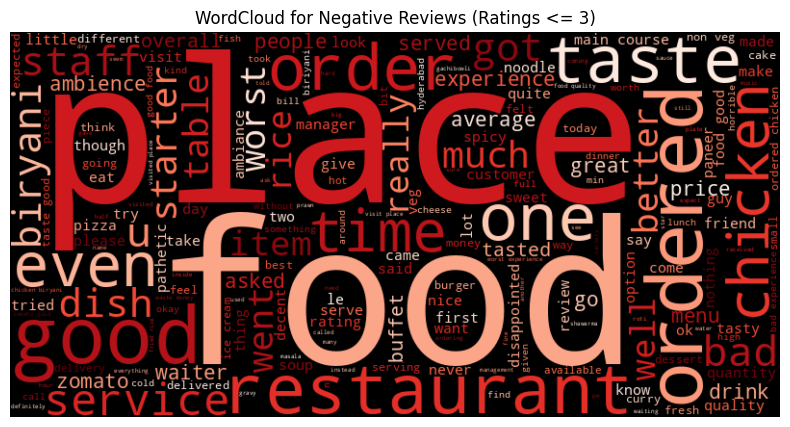

In [ ]:
negative_reviews = ' '.join([' '.join(tokens) for tokens in df[df['Rating'] <= 3]['Processed_Text']])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Negative Reviews (Ratings <= 3)')
plt.show()


## 4. Random Forest



In [ ]:
import gensim
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment import SentimentIntensityAnalyzer

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Ensure no NaN values in ratings
df.loc[df['Rating'].isnull(), 'Rating'] = 0

# Prepare features
X = df['Processed_Text']
X_sentiment = df['Sentiment']
y = df['Rating']

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(X, vector_size=100, window=5, min_count=1, workers=4)

# Function to convert reviews to Word2Vec embeddings
def review_to_vector(review):
    words = review
    word_vectors = []
    for word in words:
        if word in word2vec_model.wv:
            word_vectors.append(word2vec_model.wv[word])
    return sum(word_vectors) / len(word_vectors) if word_vectors else [0]*100  # Return mean vector

# Convert reviews to vectors
X_vectors = [review_to_vector(review) for review in X]

# Create a DataFrame for features
X_vectors_df = pd.DataFrame(X_vectors)

# Add the Sentiment score as a feature
X_vectors_df['Sentiment'] = X_sentiment.values

# Ensure all features are float
X_vectors_df = X_vectors_df.astype(float)

# Ensure all column names and the index are strings
X_vectors_df.columns = X_vectors_df.columns.astype(str)
X_vectors_df.index = X_vectors_df.index.astype(str)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectors_df, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = regressor.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Function to predict rating for a new review
def predict_rating(review_text):
    processed_review = preprocess_text(review_text)
    review_vector = review_to_vector(processed_review)
    sentiment_score = sia.polarity_scores(review_text)['compound']

    # Prepare input for prediction
    input_features = pd.DataFrame([[*review_vector, sentiment_score]])
    input_features = input_features.astype(float)  # Ensure input features are float
    predicted_rating = regressor.predict(input_features)
    return predicted_rating[0]

# Test the model with an example review
new_review = input("Enter a restaurant review: ")
predicted_rating = predict_rating(new_review)
print(f"Predicted Rating: {predicted_rating:.2f}")

Mean Squared Error: 0.7452276657793746
R^2 Score: 0.6601962250517168
Enter a restaurant review: food was not bad
Predicted Rating: 3.12


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 5.  Ridge and Bayesian Regression

In [ ]:
import numpy as np
import pandas as pd
import gensim
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from collections import defaultdict
import math

# TF-IDF Functions
def compute_tf(tokenized_review):
    tf = defaultdict(int)
    for word in tokenized_review:
        tf[word] += 1
    total_words = len(tokenized_review)
    for word in tf:
        tf[word] /= total_words
    return tf

def compute_idf(corpus):
    N = len(corpus)
    idf = defaultdict(int)
    for review in corpus:
        unique_words = set(review)
        for word in unique_words:
            idf[word] += 1
    for word in idf:
        idf[word] = math.log(N / (1 + idf[word]))  # Avoid division by zero
    return idf

def compute_tfidf(tokenized_review, idf):
    tf = compute_tf(tokenized_review)
    tfidf = {}
    for word in tf:
        tfidf[word] = tf[word] * idf.get(word, 0.0)
    return tfidf

def tfidf_to_vector(tfidf_dict, vocabulary):
    vector = np.zeros(len(vocabulary))
    word_index = {word: idx for idx, word in enumerate(vocabulary)}
    for word, score in tfidf_dict.items():
        if word in word_index:
            vector[word_index[word]] = score
    return vector

# Function to add bias
def add_bias(X):
    bias = np.ones((X.shape[0], 1))
    return np.hstack((bias, X))

# Ridge Regression
def linear_regression_ridge(X, y, alpha=1.0):
    X_transpose = X.T
    identity_matrix = np.identity(X.shape[1])
    beta = np.linalg.inv(X_transpose.dot(X) + alpha * identity_matrix).dot(X_transpose).dot(y)
    return beta

# Manual Bayesian Regression
def bayesian_linear_regression(X, y, sigma_prior=1.0, sigma_likelihood=1.0):
    X_transpose = X.T
    posterior_cov = np.linalg.inv((X_transpose.dot(X) / sigma_likelihood) + (np.identity(X.shape[1]) / sigma_prior))
    posterior_mean = posterior_cov.dot(X_transpose).dot(y) / sigma_likelihood
    return posterior_mean, posterior_cov

# Function to preprocess a new review
def preprocess_new_review(review, vocabulary, idf):
    tokens = preprocess_text(review)
    tfidf = compute_tfidf(tokens, idf)
    vector = tfidf_to_vector(tfidf, vocabulary)
    return vector

# Prediction Function with rating limits
def predict_new_review(review, vocabulary, idf, beta_linear, beta_bayesian):
    vector = preprocess_new_review(review, vocabulary, idf)
    vector_bias = np.insert(vector, 0, 1.0)  # Insert 1 for bias

    # Predictions
    pred_linear = vector_bias.dot(beta_linear)
    pred_bayesian = vector_bias.dot(beta_bayesian)

    # Limit predictions between 0 and 5
    pred_linear = max(0, min(5, pred_linear))
    pred_bayesian = max(0, min(5, pred_bayesian))

    return pred_linear, pred_bayesian

# Preprocess reviews
df['Processed_Text'] = df['Review'].apply(preprocess_text)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df.dropna(subset=['Rating'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Compute IDF and TF-IDF Matrix
idf = compute_idf(df['Processed_Text'])
vocabulary = sorted(list(set(word for review in df['Processed_Text'] for word in review)))
tfidf_vectors = df['Processed_Text'].apply(lambda x: compute_tfidf(x, idf))
tfidf_matrix = np.array([tfidf_to_vector(tfidf, vocabulary) for tfidf in tfidf_vectors])

# Split Data
X = tfidf_matrix
y = df['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add bias to the feature matrix
X_train_bias = add_bias(X_train)
X_test_bias = add_bias(X_test)

# Train Ridge Regression model (beta_linear)
alpha = 0.1  # Regularization strength
beta_linear = linear_regression_ridge(X_train_bias, y_train, alpha)

# Train Bayesian Regression model (beta_bayesian)
sigma_prior = 1.0
sigma_likelihood = 1.0
beta_bayesian, _ = bayesian_linear_regression(X_train_bias, y_train, sigma_prior, sigma_likelihood)



In [ ]:
import pandas as pd

# Get the user review
user_review = input("Enter a restaurant review: ")

pred_linear, pred_bayesian = predict_new_review(
    user_review,
    vocabulary,
    idf,
    beta_linear,     # Linear Ridge Regression coefficients
    beta_bayesian    # Bayesian regression coefficients
)

predicted_rating = predict_rating(user_review)

# Create a DataFrame to store the ratings
ratings_df = pd.DataFrame({
    "Model": ["Linear Regression - Ridge", "Bayesian Regression", "RandomForest Prediction"],
    "Predicted Rating": [pred_linear, pred_bayesian, predicted_rating]
})

# Display the DataFrame
print("\n\nPredicted ratings:\n")
print(ratings_df)
print("\n")


Enter a restaurant review: food was ok


Predicted ratings:

                       Model  Predicted Rating
0  Linear Regression - Ridge          3.347039
1        Bayesian Regression          3.225639
2    RandomForest Prediction          3.212361




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 6. Final Evaluation

In [ ]:
mse_linear = mean_squared_error(y_test, X_test_bias.dot(beta_linear))
mse_bayesian = mean_squared_error(y_test, X_test_bias.dot(beta_bayesian))
mse_rf = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, X_test_bias.dot(beta_linear))
r2_bayesian = r2_score(y_test, X_test_bias.dot(beta_bayesian))
r2_rf = r2_score(y_test, y_pred)
results = pd.DataFrame({
    'Model': ['Random Forest', 'Ridge Regression', 'Bayesian Regression'],
    'Mean Squared Error': [mse_rf, mse_linear, mse_bayesian],
    'R^2 Score': [r2_rf, r2_linear, r2_bayesian]
})

# Display the results
print(results)

                 Model  Mean Squared Error  R^2 Score
0        Random Forest            0.745228   0.660196
1     Ridge Regression            1.167667   0.467575
2  Bayesian Regression            0.928766   0.576508


**Conclusion**:

Best Performing Model:

1. Random Forest outperforms the others with the lowest Mean Squared Error (MSE) of 0.742006 and the highest R² score of 0.661665.
Interpretation of Results:

2. MSE: A low value for Random Forest indicates accurate predictions close to actual ratings.
R² Score: An R² score of 0.661665 suggests that 66.17% of the variance in ratings is explained by the model, indicating a good fit.
Why Random Forest is Preferred:

3. Robustness: It reduces overfitting through ensemble learning.
Feature Importance: It can highlight important features for further analysis.
Non-linearity: It effectively captures complex relationships in the data.